<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# RBM Deep Dive with Tensorflow 

In this notebook we provide a complete walkthrough of the Restricted Boltzmann Machine (RBM) algorithm with applications to recommender systems. In particular, we use as a case study the [movielens dataset](https://movielens.org), comprising user's ranking of movies on a scale of 1 to 5. A quickstart version of this notebook can be found [here](../00_quick_start/rbm_movielens.ipynb).  

### Overview 

A Restricted Boltzmann Machine (RBM) is a generative neural network model typically used to perform unsupervised learning. The main task of an RBM is to learn the joint probability distribution $P(v,h)$, where $v$ are the visible units and $h$ the hidden ones. The hidden units represent latent variables while the visible units are clamped on the input data. Once the joint distribution is learnt, new examples are generated by sampling from it.    

The implementation presented here is based on the article by Ruslan Salakhutdinov, Andriy Mnih and Geoffrey Hinton [Restricted Boltzmann Machines for Collaborative Filtering](https://www.cs.toronto.edu/~rsalakhu/papers/rbmcf.pdf) with the exception that here we use multinomial units instead of the one-hot encoded used in the paper.  

### Advantages of RBM: 

The model generates ratings for a user/movie pair using a collaborative filtering based approach. While matrix factorization methods learn how to reproduce an instance of the user/item affinity matrix, the RBM learns its underlying probability distribution. This has several advantages: 

- Generalizability : the model generalize well to new examples as long as they do not differ much in probability
- Stability in time: if the recommendation task is time-stationary, the model does not need to be trained often to accomodate new ratings/users. 
- The tensorflow implementation presented here allows fast, scalable  training on GPU 

### Outline 

This notebook is organized as follows:

1. RBM Theory 
2. Tensorflow implementation and model parameters  
3. Data preparation and inspection
4. Model application, performance and analysis  

Sections 1 and 2 require basic knowledge of linear algebra, probability theory and tensorflow while  
sections 3 and 4 only require some basic data science understanding. **Feel free to jump to the section you are most interested in!**

## 0 Global Settings and Import

In [1]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

# set the environment path to find Recommenders
import sys

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

#RBM 
from recommenders.models.rbm.rbm import RBM
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.sparse import AffinityMatrix

#Evaluation libraries
from recommenders.datasets import movielens 

from recommenders.evaluation.python_evaluation import (
    map_at_k,
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
)

#For interactive mode only
%load_ext autoreload
%autoreload 2

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
Pandas version: 1.3.5
Tensorflow version: 2.7.0


## 1. RBM Theory 

## 1.1 Overview and main differences with other recommender algorithms

A Restricted Boltzmann Machine (RBM) is an undirected graphical model originally devised to study the statistical mechanics (or physics) of magnetic systems. Statistical mechanics (SM) provides a probabilistic description of complex systems made of a huge number of constituents (typically $\sim 10^{23}$); instead of looking at a particular instance of the system, the aim of SM is to describe their **typical** behaviour. This approach has been succesfull for the description of gases, liquids, complex materials (e.g. semiconductors) and even the famous [Higgs boson](https://en.wikipedia.org/wiki/Higgs_boson)!

Being designed to handle and organize a large amount of data, SM finds ideal applications in modern learning algorithms. In the context of **recommender systems**, the idea is to learn typical user behaviour instead of particular instances. To better understand this consider the most general setup of a recommendation problem: there are $m$ users rating $n$ items according to some scale (e.g. 1 to 5). In a typical scenario of online shopping, streaming services or decision processes, the user only rates a subset $l \ll m$ of the products. If we now create a matrix representation of this problem, we obtain the user/item affinity matrix $X$. In a more readable table form, $X$ will look like this:


|  $X$   |$i_1$  |$i_2$  |$i_3$  |  ... |$i_m$  | 
|-----|-------|-------|-------|------|-------|
|$u_1$|5      |0      |2      |0 ... |1      |
|$u_2$|0      |0      |3      |4 ... |0      |
|...  |...    |...    |...    |...   |...    |
|$u_m$|3      |3      |0      |5...  |2      |


where the zeroes denote unrated items. In a nutshell, the recommender task is to "fill in" the missing ratings (later we will see that in practice this is not the only criteria used to recommend a product). The classical approach to this problem is called matrix factorization: the basic idea is to decompose $X$ into a user ($P$) and item ($Q$) matrix, such that $X = Q^T P$. The dimensions of the two matrices are $dim(Q) = (f, n)$ and $dim(P)= (f,m)$ where $f \le m,n$ is the number of latent factors, e.g. the genre of a movie, the type of food etc... and it is an hyperparameter of the model, for more details see the [ALS notebook](../02_model/als_deep_dive.ipynb). By learning $Q$ and $P$ we try to reproduce a particular instance of $X$ (provided by the available data) and use this information to fill up the missing matrix elements. 

The RBM approach is to look at $X$ as a particular realization (sample) of a more general process; instead of learning a specific $X$, we try to learn the matrix distribution from which $X$ has been sampled from. Effectively, we learn the typical distribution of *tastes* (i.e. latent factors) and use this information to *generate* new ratings. For this reason, this class of neural network models is also called **generative**. Consider the following example: imagine you are given the  income distribution per age window of a particular country (this is easy to find from goverments data), then we could fix the age window and *generate* virtual citizens with various incomes by sampling from this distibution.   

## 1.2 Model 

The central quantity of every SM model is the [Boltzmann distribution ](https://en.wikipedia.org/wiki/Boltzmann_distribution); this can be seen as the least biased probability distribution on a given probability space $\Sigma$ and can be obtained using a maximum entropy principle on the space of distributions over $\Sigma$. Its typical form is: 

$$P = \frac{1}{Z} \, e^{- \beta \, H},$$ 

where $Z$ is a normalization constant known as the partition function, $\beta$ is a noise parameter with units of inverse energy and $H$ is the Hamiltonian, or energy function of the system. For this reason, this class of models is also known as *energy based* in computer science. In physics, $\beta$ is the inverse temperature of the system in units of Boltzmann's constant, but here we will effectively rescale it inside $H$, so that this is now a pure number. $H$ describes the behaviour of two sets of stochastic vectors, typically called $v_i$ (visibles) and $h_j$ (hidden). The former constitute both the input *and* the ouput of the algo (this will be clear later), while the hidden units are the latent factors we want to learn. This structure results in the following Neural Network topology:

![rbm1](https://recodatasets.z20.web.core.windows.net/images/RBM1.png)

The input of the movielens database consists of ratings from 1 to 5; we shall thus consider a discrete configuration space of $m$ visible variables, each taking values in a finite set $\chi_v = \{ 1, 2, 3,4,5 \}$. A global configuration of the system is determined by $\mathbf{v} = (v_1, v_2, ..., v_m) \in \chi_v^m$ and we reserve $0$ for an unrated movie. We also need to specify the hidden units, that we take as random binary variables $\chi_h = \{0,1 \}$ denoting if the particular unit is active or not and $\mathbf{h} = (h_1, h_2, ...,h_n) \in \chi_h^n$. The hidden units may describe attributes such as the genre of a movie; for example, given a sci-fi/horror movie, only the hidden units describing such attributes should be active. The minimal model for such a system is defined by the following Hamiltonian: 

$$H = - \sum_{i,j \in G} v_i \, w_{ij} \, h_j - \sum_{i=1}^m v_i \, a_i - \sum_{j=1}^n h_i \, b_i$$

The first term is an "interaction term", capturing the correlations between the visible and hidden units, while the other two terms are "potential terms", taking into account the bias of the units. The correlation matrix $w_{ij}$ and the two biases $a_i$ and $b_i$ are learning parameters to be fixed by the minimization of a properly defined cost function. Remember that this is an unsupervised problem, i.e. there is no real output and therefore we cannot directly minimize the error function between the prediction and the labeled data. As in every SM problem, the right quantity to minimize is the Free energy (remember that $\beta =1$)

$$ F =- \log Z =- \log \sum_{ v_i, h_i } P(v, h) $$

In the language of probability theory, the above quantity is the cumulant generating function. One way of evaluating the free energy is to use a [Markov-chain Montecarlo sampling](https://en.wikipedia.org/wiki/Monte_Carlo_method#Computer_graphics) algorithm such as the Metropolis-Hasting; here we will use instead an approximate method called Contrastive divergence, based on [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) (see below). The latter has the advantage of being faster than Montecarlo. Once the candidate $F$ has been found, we fix the learning parameters by minimizing $F$. Let us see how this works in practice in the next section. 

## 1.3 Learning Algorithm 

Instead of sampling directly from the joint probability distribution, one can evaluate the conditional distributions   

$$ P(v, h) = P(v|h) P(h) = P(h|v) P(v) $$ 

where the second equality follows from the fact that the model is undirected or, in physical terms, it is in equilibrium. Gibbs sampling essentially consists of two steps called **positive** and **negative** phases:

### Positive 

**Fix the visible units on the data and evaluate $P(h_j =1| \mathbf{v})$**, i.e. the probability that the jth hidden unit is active given the entire input vector. In practice, it is convenient to evaluate the generating function: 

$$ Z[v,b] = \prod_j \sum_{h_j = 0,1}  e^{(\sum_i w_{ij} v_i + b_j) h_j} = \prod_j \left( 1+  e^{\sum_i w_{ij} v_i + b_j} \right).$$

Taking the gradients with respect to the bias we obtain 

$$\frac{\partial}{\partial b_j}\log Z[v,b] =  \frac{1}{1+ e^{-(\sum_i w_{ij} v_i + b_j)}} = \sigma( \phi_j(v, b) ),$$

where $\phi_j(v,b) = \sum_i w_{ij} v_i + b_j $ and we have identified the logistic function $\sigma(.) \equiv P(h_j=1|v,b)$. 

**Use $\sigma$ to sample the value of $h_j$** 

### Negative 

**Use the sampled value of the hidden units to evaluate $P(v_i = q |h)$**, where $q=1,...,5$. This is given by the multinomial expression

$$ P(v_i = q |h,a) =  \prod_{v_i=1}^q e^{v_i (\sum_j w_{ij} \, h_j + a_i ) }/Z_q $$

where $Z_q$ is the partition function evaluated over the $q$ outcomes (note that $0$ should not be included in the sum). Finally, sample the values of $v_i$ from the above distribution. Clearly, these new $v_i$ are not necessarily those we have used as an input, at least not at the beginning of training. The above steps are repeated $k$ times, where $k$ is usually increased during training according to a given protocol. 

At the end of each k-step Gibbs sampling, we evaluate the difference between the initial free energy at $k=0$ (given v) and the one after k-steps 

$$ \Delta F = F_0 - F_k, $$

and update the learning parameters $w_{ij}$, $b_i$ and $a_i$: 

$$ \frac{\partial}{\partial b_j} \Delta F = \frac{\partial}{\partial b_j} (\log Z_0[v,b] - \log Z_k[v,b]) = P_0(h_j=1|v,b) - P_k(h_j=1|v,b) $$

$$ \frac{\partial}{\partial w_{ij} } \Delta F = v_i \, P_0(v_i = q|h, a) - v_i P_k(v_i| h,a) \equiv \langle v_i\rangle_0 - \langle v_i \rangle_k. $$

This process is repeated for each training epoch, eventually until $\Delta F =0$, i.e. the learned distribution faithfully reproduces the empirical one. In this sense, $v_i$ serves both as an input and output of the model. As $w_{ij}$ contains informations on how users' votes are correlated, we can use this information to generate ratings for the unseen movies by sampling from the learned, marginal distribution:

$$ \langle v_i \rangle = \sum_{v_i} v_i \, P(v) $$ 

The entire workflow is summarised below 

![gibbs](https://recodatasets.z20.web.core.windows.net/images/Gsampling.png)


## 2. TensorFlow implemetation and model parameters 

In this section we briefly describe how the algorithm is implemented in Tensorflow and which parameters can be customized by the user during training. We also discuss some best practices to be used when training the RBM model on a recommendation task. Further technical details are explained directly in the code. 

Tensorflow (TF) is an open source framework to develop deep learning (DL) models in a fast and efficient way. One of the shared characteristics of DL frameworks is autodifferentiation, i.e. the symbolic evaluation of gradients, that will be particulary useful here. The other advantage of TF is the generation and optimization of the symbolic operations defined on a computational graph, for fast and scalable deployment on both CPU and GPU. For more informations on TF see [here](www.tensorflow.com). Unfortunately, TF is tailor made for supervised learning tasks, so its application to unsupervised model needs some more work. Note: although TF has recently started developing a [set of libraries to perform probabilistic inference](www.tensorflow_probability.com), we found their performance still not optimal and therefore we will not use them here. 


The RBM model is instantiated as a class with several methods to build the graph, perform sampling, training and inference. The skeleton of the graph is built at the moment the class is instantiated; mandatory fields are: 

- `hidden_units` integer (Default =500) : number of hidden units


- `training_epoch`integer (Default = 20): number of training epochs 


- `minibatch_size`integer (Default = 100): size of the batch to be chosen at random at each training epoch 


The optional parameters are: 

- `keep_prob` : float (Default = 0.7) we use dropout regularization on the hidden units, so this parameter specifies the probability of keeping the connection to a hidden unit active. Dropout will affect specific matrix elements of $w_{ij}$, decreasing in this way the model's complexity and improving generalization. 


- `sampling_protocol` : Array (Default = $[50, 70, 80,90,100]$) percentage of the entire training epochs when the the k-sampling step is increased in an annealing fashion. In the default case, the first 50% of the training epochs are sampled with a single k-step. As training converges, the number of k-steps is increased by $1$ at each percentage.


- `debug`: Boolean (Default = False) if True, prints the output of some of the intermediate steps for inspection. 


- `with_metrics`: Boolean (Default= False) if True it evaluates, print and finally plot the mean squared root error per training epoch on the training set. At the end, it also evaluates and print the total model accuracy both on the training and test set. We suggest to switch it off only for benchmarking execution time.  


- `init_stdv`: float (Default = 0.1) standard deviation used to inititialize the correlation matrix. 


- `learning_rate`: float (Default = 0.004) init learning rate used in the optimization algorithm. Note that the optimizer uses a different, effective learning rate scaled to the batch size $\alpha$ = `learning_rate/minibatch_size`. 


- `display_epoch `: integer (Default = 10) the number of epochs after which the rmse error is printed out during the learning phase. 


Although optional, it is likely that `sampling_protocol` needs to be modified for different recommenders; we recommend to keep this in mind when training on a new dataset. 

# 3 Data preparation and inspection 

The MovieLens dataset comes in different sizes, denoting the number of available ratings. The number of users and rated movies also changes across the different dataset. The data are imported in a pandas dataframe including the **user ID**, the **item ID**, the **ratings** and a **timestamp** denoting when a particular user rated a particular item. Although this last feature could be explicitely included, it will not be considered here. The underlying assumption of this choice is that user's tastes are weakly time dependent, i.e. a user's taste typically chage on time scales (usually years) much longer than the typical recommendation time scale (e.g. hours/days). As a consequence, the joint probability distribution we want to learn can be safely considered as time dependent. Nevertheless, timestamps could be used as *contextual variables*, e.g. recommend a certain movie during the weekend and another during weekdays.  

Below, we first load the different movielens data in pandas dataframes, explain how the user/affinity matrix is built and how the train/test set is generated. As this procedure is common to all the datasets considered here, we explain it in details only for the 1m dataset.  

We start with downloading the different datasets:

In [2]:
MOVIELENS_DATA_SIZE = '100k'

mldf_100k = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=['userID','movieID','rating','timestamp']
) 

mldf_100k.head()

100%|██████████| 4.81k/4.81k [00:00<00:00, 27.9kKB/s]


,userID,movieID,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [3]:
MOVIELENS_DATA_SIZE = '1m'

mldf_1m = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=['userID','movieID','rating','timestamp']
)

mldf_1m.head()

100%|██████████| 5.78k/5.78k [00:00<00:00, 25.8kKB/s]


,userID,movieID,rating,timestamp
0,1,1193,5.0,978300760
1,1,661,3.0,978302109
2,1,914,3.0,978301968
3,1,3408,4.0,978300275
4,1,2355,5.0,978824291


### 3.1 Split the data using the stratified splitter  

As a second step, we split the data into train and test set by mantaining the same matrix size. Clearly, the two matrices will contain different ratings in different proportions.  

- First, we use the `AffinityMatrix` class to generate the $(m,n)$ user/affinity matrix $X$ defined in section **1.1**; this also returns the sparseness percentage. For example, for the 1m dataset, $95$ % of the matrix entries are zeros. This represents a challenge for the learning task: fixing $95$ % of entries with only $5$ % of data points. 

- Second, use the `numpy_stratified_split()` to split $X$ into train and test set. By default, we choose a $75$% to $25$% ratio. The split function selects, for every user, $25$ % of rated movies and it moves them in the new test matrix. This way of splitting the data makes sure the rating distribution remains the same across the train/test set, both locally (user-wise) and globally. If you consider the user/item matrix $X$ defined above, we would have

### Train

|  $X_{tr}$   |$i_1$  |$i_2$  |$i_3$  |  $...$ |$i_n$  |    
|-----|-------|-------|-------|--------|-------|
|$u_1$|$0$    |$0$    |$2$    |$0...$  |$0$    |
|$u_2$|$0$    |$0$    |$3$    |$0...$  |$0$    |
|$...$|$...$  |$...$  |$...$  |$...$   |$...$  |
|$u_m$|$3$    |$0$    |$0$    |$0...$  |$2$    |


### Test 

| $X_{tst}$    |$i_1$  |$i_2$  |$i_3$  |  ... |$i_n$  | 
|-----|-------|-------|-------|------|-------|
|$u_1$|5      |0      |0      |0 ... |1      |
|$u_2$|0      |0      |0      |4 ... |0      |
|...  |...    |...    |...    |...   |...    |
|$u_m$|0      |3      |0      |5...  |0      |

The Train and Test matrices have exactly the same dimensions (i.e. same numbers of users and movies) but contain different ratings. Once the model is trained, at inference time, we use the test set user vectors to obtain the inferred values for the ratings.

In [4]:
#to use standard names across the analysis 
header = {
        "col_user": "userID",
        "col_item": "movieID",
        "col_rating": "rating",
    }

In [5]:
#instantiate the splitter 
am1m = AffinityMatrix(df = mldf_1m, **header)

#obtain the sparse matrix 
X1m, _, _ = am1m.gen_affinity_matrix()

Next, we split the matrix above into train and test set sparse matrices 

In [6]:
Xtr_1m, Xtst_1m = numpy_stratified_split(X1m)

It is useful to inspect the distribution of ratings in the test/train matrix to make sure that the splitter keeps it constant. We can inspect this by plotting the normalized histograms

[Text(0.5, 0, 'ratings'), Text(0, 0.5, 'density')]

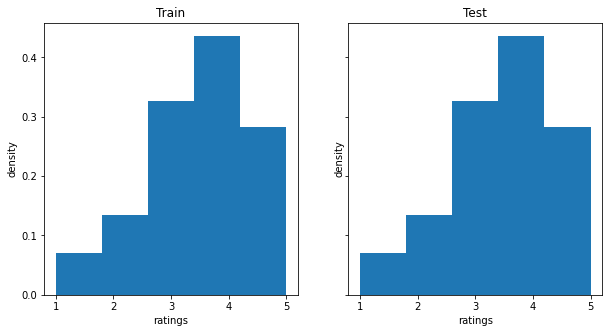

In [7]:
_, (ax1m, ax2m) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1m.hist(Xtr_1m[Xtr_1m !=0], 5, density= True)
ax1m.set_title('Train')
ax1m.set(xlabel="ratings", ylabel="density")
ax2m.hist(Xtst_1m[Xtst_1m !=0], 5, density= True)
ax2m.set_title('Test')
ax2m.set(xlabel="ratings", ylabel="density")

We now repeat the same operations for the other datasets

In [8]:
#100k
am100k = AffinityMatrix(df = mldf_100k, **header)
X100k, _, _= am100k.gen_affinity_matrix()
Xtr_100k, Xtst_100k = numpy_stratified_split(X100k)

[Text(0.5, 0, 'ratings'), Text(0, 0.5, 'density')]

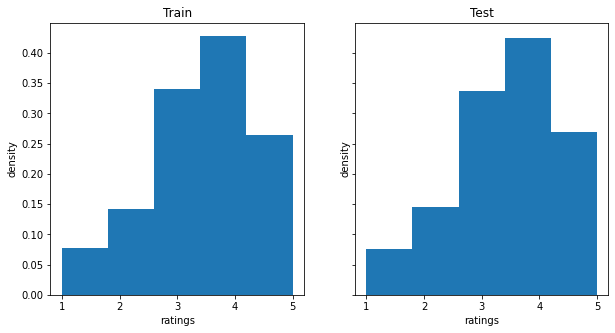

In [9]:
_, (ax1k, ax2k) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1k.hist(Xtr_100k[Xtr_100k !=0], 5, density= True)
ax1k.set_title('Train')
ax1k.set(xlabel="ratings", ylabel="density")
ax2k.hist(Xtst_100k[Xtst_100k !=0], 5, density= True)
ax2k.set_title('Test')
ax2k.set(xlabel="ratings", ylabel="density")

From the plots above we can see that the two datasets have very similar rating distributions. The main difference is in the degree of sparsness of the user/item affinity matrix; this is an important factor as it states the ratio between datapoints and unrated movies to infere. Note that the split function returns the total (or per dataset) sparsness, not the user-wise one. 

In [10]:
#collection of evaluation metrics for later use
def ranking_metrics(
    data_size,
    data_true,
    data_pred,
    K
):

    eval_map = map_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)

    eval_ndcg = ndcg_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                      col_rating="rating", col_prediction="prediction", 
                      relevancy_method="top_k", k= K)

    eval_precision = precision_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                               col_rating="rating", col_prediction="prediction", 
                               relevancy_method="top_k", k= K)

    eval_recall = recall_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                          col_rating="rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= K)

    
    df_result = pd.DataFrame(
        {   "Dataset": data_size,
            "K": K,
            "MAP": eval_map,
            "nDCG@k": eval_ndcg,
            "Precision@k": eval_precision,
            "Recall@k": eval_recall,
        }, 
        index=[0]
    )
    
    return df_result

# 4. Model application, performance and analysis of the results  

The model has been implemented as a Tensorflow (TF) class with the TF session hidden inside the `fit()` method, so that no explicit call is needed. The algorithm operates in three different steps: 

- Model initialization: This is where we tell TF how to build the computational graph. The main parameters to specify are the number of hidden units, the number of training epochs and the minibatch size. 

- Model fit: This is where we train the model on the data. The method takes two arguments: the training and test set matrices. Note that the model is trained **only** on the training set, the test set is used to display the test set accuracy of the trained model, that in turn is an estimation of the generazation capabilities of the algorithm. It is generally useful to look at these quantities to have a first idea of the optimization behaviour.  

- Model prediction: This is where we generate ratings for the unseen items. Once the model has been trained and we are satisfied with its overall accuracy, we sample new ratings from the learned distribution. In particular, we extract the top_k (e.g. 10) most relevant recommendations according to some predefined scorea. The prediction is then returned in a dataframe format ready to be analysed and deployed.  

## 4.1 1m Dataset

In [11]:
#First we initialize the model class
model_1m = RBM(hidden_units= 1200, training_epoch = 30, minibatch_size= 350, with_metrics=True)

Note that the first time the fit method is called it may take longer to return the result. This is due to the fact that TF needs to initialized the GPU session. You will notice that this is not the case when training the algorithm the second or more times. As for the `minibatch_size`, you would like to choose a value that gives you a good generalization error while mantaining a reasonable running time. The lower the size, the closer you get to stochastic gradient descent, but training takes longer. A big size value (say 1/2 of batch size) will speed up training but will increase the generalization error.     

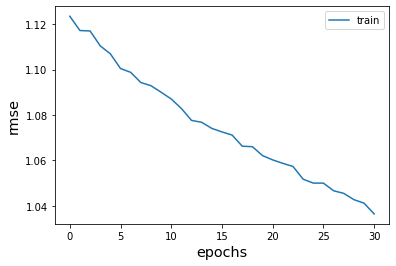

In [12]:
#Model Fit
model_1m.fit(Xtr_1m, Xtst_1m)

During training, we evauate the root mean squared error to have an idea of how learning is proceeding. Remember that in the RBM this is not the quantity being minimized, but plotting the rmse per epoch gives us a rough understanding of how learning is proceeding and how we should adjust the hyper parameters. Generally, we would like to see the rmse decrease monotonically as a function of the learning epochs. Even though you may be using an automated hyper parameter optimization method, I strongly suggest to spend some time to manually inspect the learning process; this will give you an idea of the value range to expect for the hyperparameters. Finally, note that most automated hyperparameters search methods are optimized for supervised learning, so they may not work as well for unsupervised tasks. 

The two final scores are the train/test mean average accuracies across the all set together with their difference. This has been defined as: 

$$ AC = \frac{1}{m} \sum_{\mu=1}^{m} \sum_{i=1}^{N_v} \frac{1}{s_i} \, I(v=vp)_{\mu,i}, $$

where $m$ = total number of users, $N_v$ = Total number of items $\equiv$ number of visible units and $s_i$= the number of non-zero elements per row, i.e. the per user total number of ratings. 
Remember that for a model to generalize well, the difference between train and test metrics should not be too big. In order to visualize these online metrics, choose `with_metrics =True` in the `RBM()` model function. When evaluating metrics, the model takes a bit longer to run, but you need to do so only in the exploratory phase of your work

### 4.1.2 Model Evaluation

To evaluate the model performance and compare it against the other algorithms in this repository, we use the `recommend_k_items()` method. Note that we pass 'maps' as a second argument in order to return the correct user/item IDs in a pandas dataframe format.  

In [13]:
#number of top score elements to be recommended  
K = 10

#Model prediction on the test set Xtst. 
top_k_1m =  model_1m.recommend_k_items(Xtst_1m)

top_k returns the first K elements having the highest recommendation score. Here the recommendation score is evaluated by multiplying the predicted rating by its probability, i.e. the confidence the algorithm has about its output. So if we have two items both with predicted ratings 5, but one with probability 0.5 and the other 0.9, the latter will be considered more relevant. In order to inspect the prediction and use the evaluation metrics in this repository, we convert both top_k and Xtst to pandas dataframe format:

In [14]:
top_k_df_1m = am1m.map_back_sparse(top_k_1m, kind = 'prediction')
test_df_1m = am1m.map_back_sparse(Xtst_1m, kind = 'ratings')

In [15]:
rating_1m= ranking_metrics(
    data_size = "mv 1m",
    data_true =test_df_1m,
    data_pred =top_k_df_1m,
    K =10)

rating_1m

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,mv 1m,10,0.272355,0.679737,0.574967,0.311581


Formally, one should train the model until the cost function becomes flat but often an "early stopping" does the job. In the above example, we decided to train the algorithm to achieve higher ranking metrics. A faster optimization will do as well, but it will decrease the ranking metrics. 

## 4.2 100k Dataset

In [16]:
#100k
model_100k = RBM(hidden_units= 600, training_epoch = 30, minibatch_size= 60,keep_prob= 0.9, with_metrics = True)

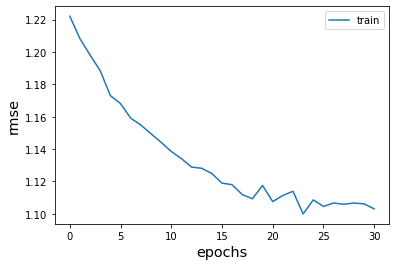

In [17]:
model_100k.fit(Xtr_100k, Xtst_100k)

In [18]:
#Model prediction on the test set Xtst. 
top_k_100k =  model_100k.recommend_k_items(Xtst_100k)

#to df
top_k_df_100k = am100k.map_back_sparse(top_k_100k, kind = 'prediction')
test_df_100k = am100k.map_back_sparse(Xtst_100k, kind = 'ratings')

### 4.2.1 Model evaluation 

In [19]:
eval_100k= ranking_metrics(
    data_size = "mv 100k",
    data_true =test_df_100k,
    data_pred =top_k_df_100k,
    K=10) 

eval_100k

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,mv 100k,10,0.140632,0.411135,0.341357,0.215336
